# Backdoor Unlearning

## Outline

1. Experimental setup (generating configs)
2. Clean model training
3. Poisoned model training
4. First-order unlearning
5. Second-order unlearning
6. Visualizing results


## Experimental Setup

- All configurations to test are defined in the `[train|poison|unlearn].json` files (see below).
- If parameters are passed as list, all their combinations are tested in a grid-search manner.
- Only a single combination is provided for this demo. The original combinations are in `Applications/Poisoning/configs`
- The function generates directories and configuration files for each combination. They are later used by an evaluation script to run the experiment. This allows for parallelization and distributed execution.

In [1]:
import sys
sys.path.append('../')


In [2]:
# only if you are using CUDA devices
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [3]:
#!pip install scikit-learn

In [4]:
from conf import BASE_DIR
from Applications.Poisoning.gen_configs import main as gen_configs

model_folder = BASE_DIR/'models'/'poisoning'
train_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'train.json'
poison_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'poison.json'
unlearn_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'unlearn.json'

gen_configs(model_folder, train_conf, poison_conf, unlearn_conf)

## Clean Model Training

- Train a clean model for reference.

In [5]:
#!pip install tensorflow

In [6]:
from Applications.Poisoning.train import main as train

# train one clean and one poisoned model
train(model_folder=model_folder/'clean')

/Users/utkarsh/Desktop/Unlearning/MachineUnlearning/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Train Poisoned Model

- Select one of the generated configurations and train a poisoned model.
- The poisoning uses an `injector` object which can be persisted for reproducibility. It will inject the backdoors/label noise into the same samples according to a seed. In our experiments, we worked with label noise poisoning.

In [7]:
#!pip install matplotlib

In [8]:
from Applications.Poisoning.poison.poison_models import train_poisoned
from Applications.Poisoning.configs.demo.config import Config

poisoned_folder = model_folder/'budget-10000'/'seed-42'
poison_kwargs = Config.from_json(poisoned_folder/'poison_config.json')
train_kwargs = Config.from_json(poisoned_folder/'train_config.json')
train_poisoned(model_folder=poisoned_folder, poison_kwargs=poison_kwargs, train_kwargs=train_kwargs)

In [9]:
poisoned_weights = poisoned_folder/'best_model.hdf5'       # model that has been trained on poisoned data
fo_repaired_weights = poisoned_folder/'fo_repaired.hdf5'   # model weights after unlearning (first-order)
so_repaired_weights = poisoned_folder/'so_repaired.hdf5'   # model weights after unlearning (second-order)
injector_path = poisoned_folder/'injector.pkl'             # cached injector for reproducibility
clean_results = model_folder/'clean'/'train_results.json'  # path to reference results on clean dataset


## Unlearning

- Perform the first-order and second-order unlearning. The unlearning is wrapped in a function that
    - loads the clean data, saves the original labels
    - injects the poison (label noise)
    - creates difference set Z using `injector.injected_idx`
    - main unlearning happens in `Applications.Poisoning.unlearn.common.py:unlearn_update` and the thereby called `iter_approx_retraining` method
- The variable naming follows the following ideas:
    - `z_x`, `z_y`: features (x) and labels (y) in set `Z`
    - `z_x_delta`, `z_y_delta`: changed features and labels (`z_x == z_x_delta` here and `z_y_delta` contains the original (fixed) labels)
- A word about why iterative:
    - The approximate retraining is configured to unlearn the desired changes in one step.
    - To avoid putting a lot of redundant erroneous samples in the changing set `Z`, the iterative version
        - takes a sub-sample (`prio_idx`) of `hvp_batch_size` in the delta set `Z`
        - makes one unlearning step
        - recalculates the delta set and focuses only on remaining errors
    - The idea here is that similar to learning, it is better to work iteratively in batches since the approximation quality of the inverse hessian matrix decreases with the number of samples included (and the step size)

In [10]:
#!pip install seaborn

/Users/utkarsh/Desktop/Unlearning/MachineUnlearning/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,800,842 (6.87 MB)

 Trainable params: 1,798,282 (6.86 MB)

 Non-trainable params: 2,560 (10.00 KB)

None


/Users/utkarsh/Desktop/Unlearning/MachineUnlearning/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,800,842 (6.87 MB)

 Trainable params: 1,798,282 (6.86 MB)

 Non-trainable params: 2,560 (10.00 KB)

None


ValueError: The filename must end in `.weights.h5`. Received: filepath=/Users/utkarsh/Desktop/Unlearning/MachineUnlearning/models/poisoning/budget-10000/seed-42/first-order/repaired_model.hdf5

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

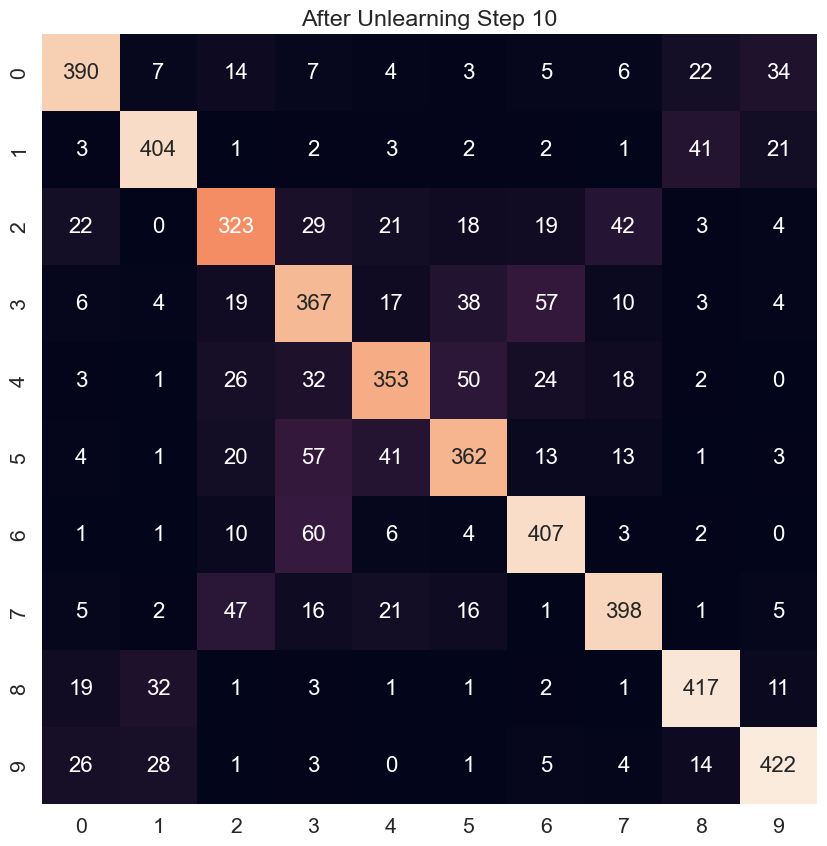

In [11]:
from Applications.Poisoning.unlearn.first_order import run_experiment as fo_experiment
from Applications.Poisoning.unlearn.second_order import run_experiment as so_experiment

fo_unlearn_kwargs = Config.from_json(poisoned_folder/'first-order'/'unlearn_config.json')
so_unlearn_kwargs = Config.from_json(poisoned_folder/'second-order'/'unlearn_config.json')

fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs)
so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs)

## Visualizing the Results

- To give some notion of how well the unlearning worked, we plot confusion matrices before and after unlearning.
- This is just an example and not required for unlearning.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

In [9]:
cm_before = mpimg.imread(poisoned_folder/'first-order'/'cm'/'cm_unlearning_00.png')
cm_after = mpimg.imread(poisoned_folder/'first-order'/'cm'/'cm_unlearning_01.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(cm_before)
ax[1].imshow(cm_after)
ax[0].grid(False)
ax[1].grid(False)
ax[0].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
ax[1].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/utkarsh/Desktop/Unlearning/MachineUnlearning/models/poisoning/budget-10000/seed-42/first-order/cm/cm_unlearning_00.png'

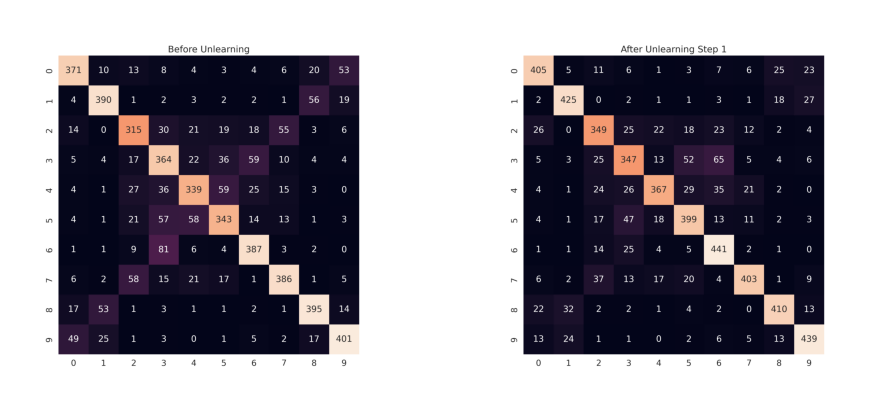

In [10]:
cm_before = mpimg.imread(poisoned_folder/'second-order'/'cm'/'cm_unlearning_00.png')
cm_after = mpimg.imread(poisoned_folder/'second-order'/'cm'/'cm_unlearning_01.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(cm_before)
ax[1].imshow(cm_after)
ax[0].grid(False)
ax[1].grid(False)
ax[0].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)
ax[1].tick_params(left=False, right=False , labelleft=False, labelbottom=False, bottom=False)

plt.show()

As you can see, the second-order unlearning is able to fix some of the missing accuracy. However, it can also be observed that the unlearning is not exact in the non-convex setting.